# Quick Start
In this comprehensive quick start, we will build a support chatbot in LangGraph that can:
- Answer common questions by searching the web
- Maintain conversation state across calls
- Route complex queries to a human for review
- Use custom state to control its behavior
- Rewind and explore alternative conversation paths

## Setup
Load API keys.

In [13]:
from dotenv import load_dotenv

load_dotenv()

True

## Part 1: Build a Basic Chatbot
We'll first create a simple chatbot using LangGraph. This chatbot will respond directly to user messages. Though simple, it will illustrate the core concepts of building with LangGraph. By the end of this section, you will have a built rudimentary chatbot.

Start by creating a StateGraph. A StateGraph object defines the structure of our chatbot as a "state machine". We'll add nodes to represent the llm and functions our chatbot can call and edges to specify how the bot should transition between these functions.

In [14]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

So now our graph knows two things:
1. Every `node` we define will receive the current `State` as input and return a value that updates that state.
2. `messages` will be appended to the current list, rather than directly overwritten. This is communicated via the prebuilt `add_messages` function in the `Annotated` syntax.
Next, add a "`chatbot`" node. Nodes represent units of work. They are typically regular python functions.

In [15]:
#from langchain_anthropic import ChatAnthropic
from langchain_groq import ChatGroq

#llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm = ChatGroq(model="gemma2-9b-it")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever the node is used.
graph_builder.add_node("chatbot", chatbot)

Notice how the `chatbot` node function takes the current `State` as input and returns a dictionary containing an updated `messages` list under the key "messages". This is the basic pattern for all LangGraph node functions.

The `add_messages` function in our `State` will append the llm's response messages to whatever messages are already in the state.

Next, add an `entry` point. This tells our graph **where to start its work** each time we run it.

In [16]:
graph_builder.add_edge(START, "chatbot")

Similarly, set a `finish` point. This instructs the graph **"any time this node is run, you can exit."**

In [17]:
graph_builder.add_edge("chatbot", END)

Finally, we'll want to be able to run our graph. To do so, call "`compile()`" on the graph builder. This creates a "`CompiledGraph`" we can use invoke on our state.

In [18]:
graph = graph_builder.compile()

You can visualize the graph using the `get_graph` method and one of the "draw" methods, like `draw_ascii` or `draw_png`.

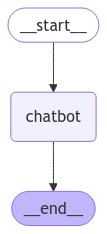

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

Now let's run the chatbot!

**Tip:** You can exit the chat loop at any time by typing "quit", "exit", or "q".

In [20]:
def stream_graph_updates(user_input: str):
    #print(f"user_input: {user_input}")
    events = graph.stream({"messages": [("user", user_input)]})
    for event in events:
        for value in event.values():
            #print(f"value: {value}")
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Precalculus and calculus are both branches of mathematics, but they build upon each other in a significant way. Here's a breakdown of the key differences:

**Precalculus:**

* **Foundation:** Precalculus serves as the bridge between algebra and calculus. It strengthens your understanding of algebraic concepts and introduces foundational ideas needed for calculus.
* **Topics:**
    * **Algebra:**  Reviews and expands upon algebra topics like functions, equations, inequalities, polynomials, rational expressions, and systems of equations.
    * **Trigonometry:**  Covers trigonometric functions (sine, cosine, tangent), their graphs, identities, and applications.
    * **Analytic Geometry:** Explores the relationship between algebra and geometry, including conic sections (circles, ellipses, parabolas, hyperbolas).
    * **Sequences and Series:** Introduces the concepts of infinite sequences and series.
* **Goal:** To prepare you for the rigor and concepts of calculus by solidifyi

## Part 2: Enhancing the Chatbot with Tools
To handle queries our chatbot can't answer "from memory", we'll integrate a web search tool. Our bot can use this tool to find relevant information and provide better responses.

In [21]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]

tool.invoke("Who won the match between Man City & Fulham today?")

[{'url': 'https://www.mancity.com/news/mens/manchester-city-v-fulham-match-report-63863731',
  'content': 'Mateo Kovacic scored twice and Jeremy Doku grabbed a vital third as City edged a hard-earned 3-2 win over Fulham. The visitors struck first after the Blues had missed several chances, with Andreas Pereira scoring for the Cottagers. But Kovacic levelled shortly after and scored his second two minutes ...'},
 {'url': 'https://www.nytimes.com/athletic/5818999/2024/10/05/manchester-city-3-fulham-2-result-kovacic/',
  'content': 'Mateo Kovacic scored twice for Manchester City as they came from behind to beat Fulham 3-2 at the Etihad Stadium.. The Croatian struck either side of half-time after Andreas Pereira had given the ...'}]

The results are page summaries our chat bot can use to answer questions.

Next, we'll start defining our graph. The following is all the **same as in Part 1**, except we have added `bind_tools` on our LLM. This lets the LLM know the correct JSON format to use if it wants to use our search engine.

In [32]:
from typing import Annotated

from langchain_groq import ChatGroq
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatGroq(model_name="gemma2-9b-it")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

Below, we implement a `BasicToolNode` that checks the most recent message in the state and calls tools if the message contains `tool_calls`. It relies on the LLM's `tool_calling` support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

We will later replace this with LangGraph's prebuilt [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) to speed things up, but building it ourselves first is instructive.

In [33]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

With the tool node added, we can define the `conditional_edges`.

Recall that **edges** route the control flow from one node to the next. **Conditional edges** usually contain "if" statements to route to different nodes depending on the current graph state. These functions receive the current graph `state` and return a string or list of strings indicating which node(s) to call next.

Below, call define a router function called `route_tools`, that checks for tool_calls in the chatbot's output. Provide this function to the graph by calling `add_conditional_edges`, which tells the graph that whenever the `chatbot` node completes to check this function to see where to go next.

The condition will route to `tools` if tool calls are present and `END` if not.

Later, we will replace this with the prebuilt [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition) to be more concise, but implementing it ourselves first makes things more clear.

In [34]:
from typing import Literal


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

**Notice** that conditional edges start from a single node. This tells the graph "any time the '`chatbot`' node runs, either go to 'tools' if it calls a tool, or end the loop if it responds directly.

Like the prebuilt `tools_condition`, our function returns the `END` string if no tool calls are made. When the graph transitions to `END`, it has no more tasks to complete and ceases execution. Because the condition can return `END`, we don't need to explicitly set a `finish_point` this time. Our graph already has a way to finish!

Let's visualize the graph we've built.

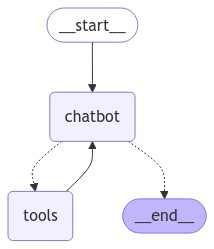

In [35]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

Now we can ask the bot questions outside its training data.

In [36]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: [{"url": "https://www.skysports.com/football/live-blog/12309/13227650/arsenal-vs-southampton-live-premier-league-match-updates-news-and-score", "content": "Follow our coverage of Arsenal vs Southampton in the Premier League, with kick-off at 3pm on Saturday. ... Premier League match updates, news and score. Trending. Liverpool dominant at Crystal ..."}, {"url": "https://www.bbc.co.uk/sport/football/premier-league/scores-fixtures/2024-10?filter=fixtures", "content": "Premier League scores, results and fixtures on BBC Sport, including live football scores"}]
Assistant: 
Assistant: [{"url": "https://www.msn.com/en-us/sports/soccer/arsenal-vs-southampton-live-premier-league-result-match-stream-latest-updates-today/ar-AA1rK4oq", "content": "LIVE - Updated at 16:30. Arsenal vs Southampton LIVE! The Gunners welcome Saints to the Emirates Stadium this afternoon looking to make amends for past sins. The last time Southampton were in ..."}, {"url": "https://www.skysports.c

## Part 3: Adding Memory to the Chatbot
Our chatbot can now use tools to answer user questions, but it doesn't remember the context of previous interactions. This limits its ability to have coherent, multi-turn conversations.

LangGraph solves this problem through **persistent checkpointing**. If you provide a `checkpointer` when compiling the graph and a `thread_id` when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same `thread_id`, the graph loads its saved state, allowing the chatbot to pick up where it left off.

We will see later that **checkpointing** is much more powerful than simple chat memory - it lets you save and resume complex state at any time for error recovery, human-in-the-loop workflows, time travel interactions, and more. But before we get too ahead of ourselves, let's add checkpointing to enable multi-turn conversations.

To get started, create a `MemorySaver` checkpointer.

In [37]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

**Notice** we're using an in-memory checkpointer. This is convenient for our tutorial (it saves it all in-memory). In a production application, you would likely change this to use `SqliteSaver` or `PostgresSaver` and connect to your own DB.

Next define the graph. Now that you've already built your own `BasicToolNode`, we'll replace it with LangGraph's prebuilt `ToolNode` and `tools_condition`, since these do some nice things like parallel API execution. Apart from that, the following is all copied from Part 2.

In [38]:
from typing import Annotated

from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatGroq(model_name="gemma2-9b-it")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Finally, compile the graph with the provided checkpointer.
graph = graph_builder.compile(checkpointer=memory)

Notice the connectivity of the graph hasn't changed since Part 2. All we are doing is checkpointing the `State` as the graph works through each node.

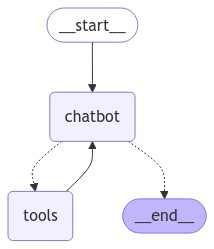

In [39]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

Now you can interact with your bot! First, pick a thread to use as the key for this conversation.

In [40]:
config = {"configurable": {"thread_id": "1"}}

Next, call your chat bot.

In [41]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_jper)
 Call ID: call_jper
  Args:
    query: What is Will's name?
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://en.wikipedia.org/wiki/Will_(given_name)", "content": "Will [wil] or Wil is a given name, often a short form (hypocorism) of William, Wilson, Wilfred, Wilbur, Wilhelmina, Wilma, Willard or Willeke."}, {"url": "https://www.thebump.com/b/wills-baby-name", "content": "Sep 27, 2024 · It has the hefty meaning of \"helmet of protection\" or \"resolute protector.\" With Wills as their name, baby will exude a calm and comforting ..."}]
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_3911)

**Note:** The config was provided as the **second positional argument** when calling our graph. It importantly is not nested within the graph inputs (`{'messages': []}`).

Let's ask a followup: see if it remembers your name.

In [42]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, your name is Will.


**Notice** that we aren't using an external list for memory: it's all handled by the checkpointer!

Don't believe me? Try this using a different config.

In [43]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_mgrq)
 Call ID: call_mgrq
  Args:
    query: Remember my name
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://en.wikipedia.org/wiki/Remember_My_Name_(film)", "content": "Remember My Name is a 1978 American black comedy-drama thriller written and directed by Alan Rudolph. It stars Geraldine Chaplin, Anthony Perkins, ..."}, {"url": "https://www.youtube.com/watch?v=LvQIZ1IqyFc", "content": "Jun 17, 2023 · Remember My Name” from the album Be the Cowboy by Mitski. Listen to Be the Cowboy: https ...Duration: 2:16Posted: Jun 17, 2023"}]
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_5weg)
 Call ID: call_5w

By now, we have made a few checkpoints across two different threads. But what goes into a checkpoint? To inspect a graph's `state` for a given config at any time, call `get_state(config)`.

In [44]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='642cc6c1-e90d-4db8-8fa1-2681adb420b0'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jper', 'function': {'arguments': '{"query":"What is Will\'s name?"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 989, 'total_tokens': 1080, 'completion_time': 0.165454545, 'prompt_time': 0.031913168, 'queue_time': 0.0030876650000000033, 'total_time': 0.197367713}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d0e34a4b-e48d-40d4-9c5b-937c1c9bc086-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': "What is Will's name?"}, 'id': 'call_jper', 'type': 'tool_call'}], usage_metadata={'input_tokens': 989, 'output_tokens': 91, 'total_tokens': 1080}), ToolMessag

In [45]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()

The snapshot above contains the current state values, corresponding config, and the `next` node to process. In our case, the graph has reached an `END` state, so `next` is empty.

Your chatbot can now maintain conversation state across sessions thanks to LangGraph's checkpointing system. This opens up exciting possibilities for more natural, contextual interactions. LangGraph's checkpointing even handles **arbitrarily complex graph states**, which is much more expressive and powerful than simple chat memory.